## Space Mission Case Study

This case study demonstrates using Pacti for the design and analysis of operational space mission scenarios. Normally, designing and analyzing such space missions and their scenarios involves complex simulation models covering the significant interactions that can influence the behavior of the systems involved. Several factors drive the complexity of such simulation models including the scope of subsystem interactions and the cross-domain interactions that require coordination among multiple domain experts. Is there a simpler way to explore the salient aspects of a space mission design/analysis problem than building a complex simulation? We believe that Pacti shows such a simpler approach; however, it requires switching the design paradigm from simulation-based to [contract-based](). -- TODO: cite Alberto's Frankenstein paper & Bienveniste's book.

This case study focuses on the problem of operating a CubeSat-sized spacecraft/small-body asteroid rendezvous mission as described in detail in [Nesnas et al. 2021](ref5). For autonomous operation, this would involve an onboard planning/scheduling system based on a generalized timeline representation as described in [Chien et al. 2012](#ref1). Examples of such timeline representation modeling include [Rabideau et al. 2017](#ref2) and [Chen et al. 2003](#ref3). Such systems reflect deliberate design decisions to limit the expressiveness of constraint formulas for planning/scheduling due to considerations of the limited computational resources available on space mission systems and performance requirements for computing solutions. In contrast to the general class of 1st order constraint formulas of PDDL (see [Ghallab et al. 1998](#ref4)), such systems involve computationally efficient linear inequalities of the form:

$$aX <= b$$

where $x$ is a timeline variable and $a,b$ are constants that may encode temporal information about the schedule of a task instance.

Since this class of constraint formula fits the expressiveness of Pacti's polyhedral constraints, this case study explores modeling tasks for an onboard automated planning/scheduling system as assume-guarantee components using Pacti.

In [1]:
from IPython import display
from base64 import b64decode
from contract_utils import *

## A simple space mission scenario

The following figure illustrates a simplification of the CubeSat-sized spacecraft/small-body asteroid approach scenario described in more detail in [Nesnas et al. 2021](ref5). Note: the Sun, Earth, spacecraft and small-body asteroid are shown at different scales for illustration purposes.

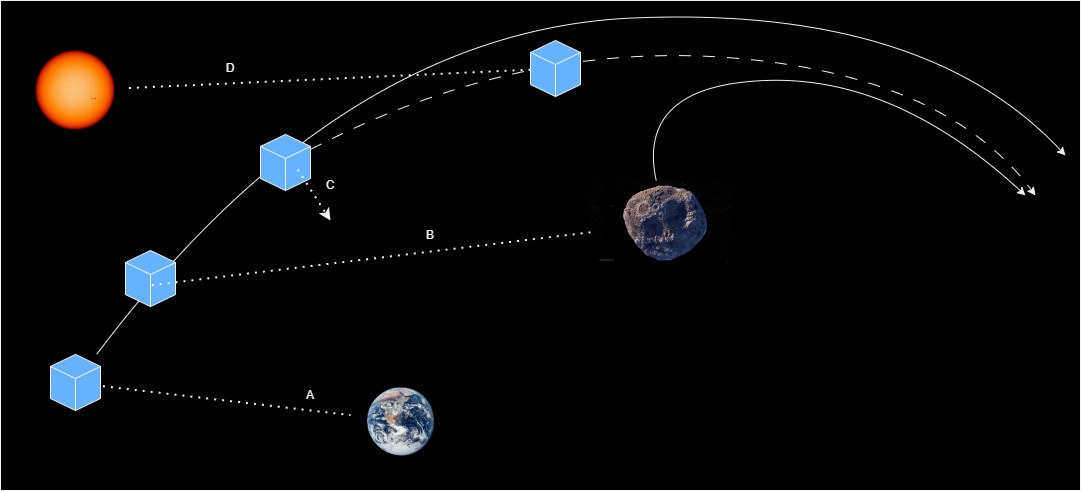

In [2]:
display.Image(b64decode(figure_space_mission_scenario))


To communicate with Earth, the cubesat-sized spacecraft (blue cube) must orient its fixed antennas towards Earth (line A). Depending on the trajectory, this orientation may be suboptimal for the spacecraft panels to produce maximum electrical power (line B). The spacecraft must make optical measurements of the small body asteroid to estimate its relative trajectory (line C) as part of the onboard autonomous navigation. This navigation requires pointing the spacecraft's thrusters in the direction of a velocity vector (line D) according to a trajectory correction maneuver (TCM). After several carefully designed TCMs, the spacecraft will eventually reach the small body asteroid and land on it as described in [Nesnas et al. 2021](ref5). For onboard planning/scheduling these behaviors would be modeled as tasks in the style of [Rabideau et al. 2017](#ref2) and [Chen et al. 2003](#ref3); that is, tasks would involve linear inequality constraints for specifying their pre/post conditions and their effects. The following describes the specification of these behaviors in Pacti's assume-guarantee paradigm.

### Modeling task behaviors as assume-guarantee contracts

The simplified space mission scenario described above involves the following tasks:

| Task Name | Task Description | Pointing Constraint |
| --------- | ---------------- | ------------------- |
| DSN       | Communicate with Earth | Line A |
| SBO       | Acquire Small body observations | Line B |
| TCM       | Perform a Trajectory Correction Maneuver | Line C |
| CHARGING  | Ensure power | Line D |

Planning and scheduling these tasks will result in a scenario of task instances as illustrated below where red dashed rectangles show the temporal extent of each scheduled task instance. 


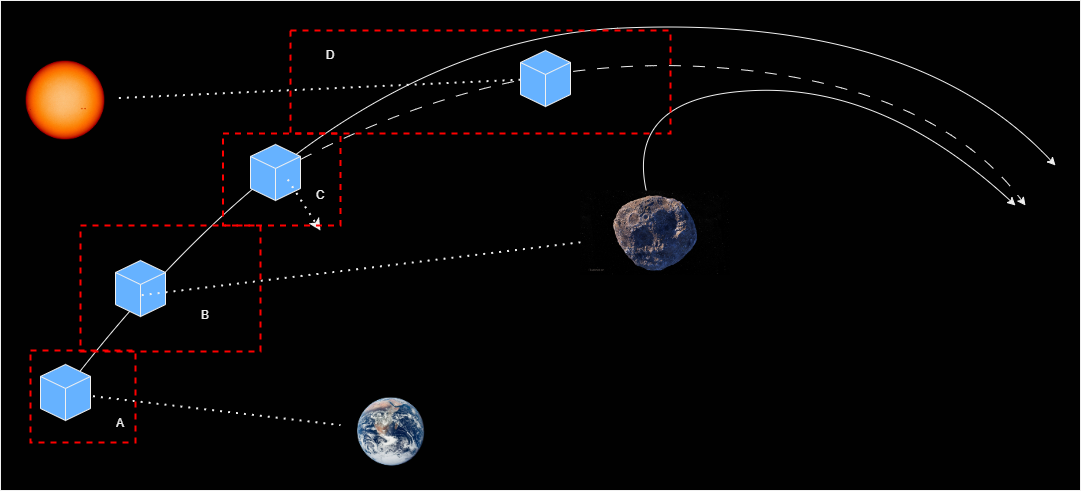

In [3]:
display.Image(b64decode(figure_space_mission_segments))

To help stakeholders understand the constraints involved in planning/scheduling these tasks, it is necessary to characterize their impacts on key system states as described below:

| Variable name | Value range | Variable description |
| ------------- | ----------- | -------------------- |
| `t` | $[0-..]$ | time |
| `soc` | $[0-100]$ | Spacecraft's battery state-of-charge |
| `d` | $[0-100]$ | Spacecraft's current onboard science data storage from small body observations |
| `c` | $>= 0$ | Spacecraft cummulative science data from small body observations |
| `u` | $[0-100]$ | Spacecraft-small-body relative trajectory uncertainty |
| `r` | $[0-100]$ | Spacecraft's relative distance (100=trajectory at beginning of scenario, 0=trajectory at rendez-vous with small body) |
| `temp` | $[0-100]$ | Spacecraft's thurster temperature (0=cold, 100=hot) |

#### Qualitative Impacts

The following table summarizes a rough qualitative description of each task's impacts on the system states with a simple scale, `+`, `0`, and `-`, for, respectively, increase, no change, or decrease.


| Viewpoint  | State | CHARGING | DSN | SBO | TCM |
|:----------:|:-----:|:--------:|:---:|:---:|:---:|
| Power      | `soc` |   +      |  -  |  -  |  -  |
| Science    | `d`   |   0      |  -  |  +  |  0  |
|            | `c`   |   0      |  0  |  +  |  0  |
| Navigation | `u`   |   +      |  +  |  -  |  +  |
|            | `r`   |   0      |  0  |  0  |  +  |
| Thermal    | `temp`|   -      |  -  |  -  |  +  |

For power, only the CHARGING task ensures the optimal orientation of the spacecraft's solar panels for charging the battery. All other tasks consume power where the spacecraft attitude pointing requirements may result in a net discharge of the battery. 

For science & communication, the onboard science data storage will evolve up and down according to the SBO and DSN tasks respectively while the cumulative science data will increase with SBO tasks. 

For navigation, the relative trajectory estimation uncertainty grows with tasks that require spacecraft attitude changes (i.e. CHARGING, DSN, and SBO); the only way to reduce this estimation uncertainty is to perform direct optical measurements in the SBO task to refine the onboard navigation trajectory estimate. The TCM task performs so-called delta-V maneuvers calculated to improve the spacecraft's relative distance from the small body. 

For thermal, each delta-V maneuver in a TCM task requires pre-heating the spacecraft thrusters that otherwise cool off very quickly during all other tasks.

While this qualitative characterization suffices to convey a sense of the phenomena involved, we need a quantitative characterization to explore the feasibility of mission scenarios from a planning/scheduling perspective and to explore different scenario strategies. The following diagram illustrates a quantitative characterization of a scenario using Pacti's polyhedral algebra for specifying assume/guarantee constraints over input/output variables. Each task instance in the scenario has a corresponding contract (e.g. A and B in the figure example). By forcing the input of a subsequent task (e.g. B) to be equal to the outputs of a previous task (e.g. A), we can thus encode a temporal ordering constraint for these tasks (i.e., B starts immediately after A finishes). Modeling task instance duration as an explicit input variable (e.g. $duration_A$), we can model quantitative linear relationships about the task behavior as a function of its duration. 

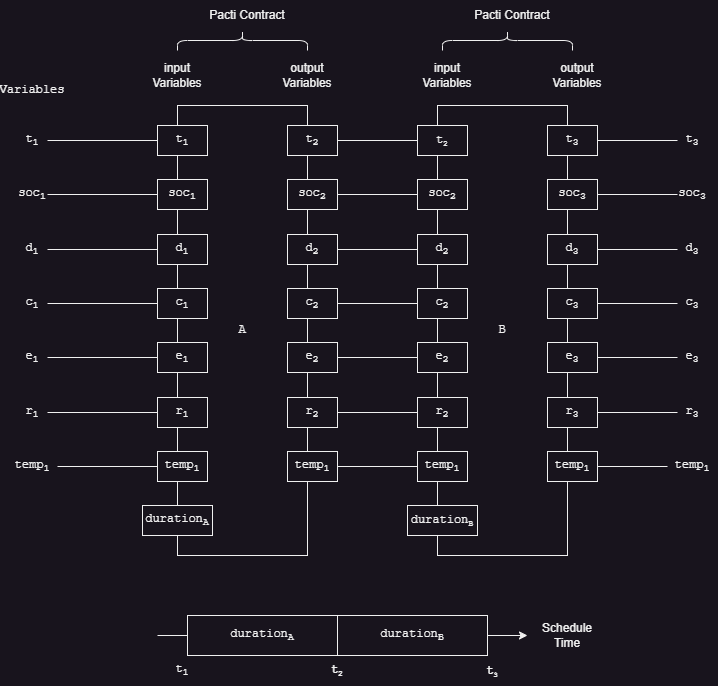

In [4]:
display.Image(b64decode(figure_task_schedule_contracts))

This approach was initially attractive because it resembles what current planning/scheduling systems do: propagating values of state variables across the impacts of scheduled task instances. However, this approach turned out to be impractical because adding more variables leads to significant practical hurdles:
- it is difficult to tell whether viewpoints are coupled or not;
- plotting convex regions of admissible values becomes more difficult because such regions could have a dimension > 2, thereby requiring some kind of projection to visualize;
- it prevents collaborative engineering where different experts could work independently on modeling their viewpoints separately;
- it prevents detecting when it becomes necessary to couple viewpoints, an important indicator of domain complexity that warrants careful analysis.

For these reasons, this case study is split into distinct viewpoints for power, data, navigation, and thermal.

#### Mission scenario requirements

At the mission level, we can specify an end-to-end mission scenario requirement as assumptions/guarantees over the system state variables as shown below. Note that the scenario requirement omits any reference to the task duration as these must remain unconstrained so that Pacti can compute an admissible schedule by finding values of task durations that satisfy all task constraints.

In [5]:
scenario_requirements = PolyhedralContract.from_string(
    input_vars = [
        "t_entry",    # scenario start time
        "soc_entry",  # initial battery SOC
        "d_entry",    # initial data storage volume
        "c_entry",    # initial cumulative data volume
        "u_entry",    # initial trajectory uncertainty
        "r_entry",    # initial relative distance
        "temp_entry", # initial spacecraft thruster temperature
    ],
    output_vars = [
        "t_exit",     # scenario end time
        "soc_exit",   # final battery SOC
        "d_exit",     # final data storage volume
        "c_exit",     # final cumulative data volume
        "u_exit",     # final trajectory uncertainty
        "r_exit",     # final relative distance
        "temp_exit",  # final spacecraft thruster temperature
    ],
    assumptions = [
        "t_entry = 0",      # start @ t=0
        "soc_entry = 100",  # start with battery fully charged
        "d_entry = 0",      # start with no science data storage
        "c_entry = 0",      # start with no cumulative science data
        "u_entry = 20",     # start with trajectory estimation uncertainty = 20% (ground-based calculations)
        "r_entry = 100",    # start with relative distance = 100%
        "temp_entry = 0",   # start with cold thruster temperature
    ],
    guarantees = [
        "t_exit = 300",     # projected end @ t=300
        "-soc_exit <= 70",  # goal: battery >= 70% SOC
        "d_exit = 0",       # goal: all science data downlinked
        "-c_exit <= -1e4",  # goal: at least 10^4 cumulative science data observations
        "u_exit <= 1",      # goal: trajectory estimation uncertainty <= 1%
        "r_exit <= 10",     # goal: relative distance below 10%
        "-r_exit <= -5",    # goal: relative distance above 5%
        "-temp_exit <= 0",  # goal: no constraint on thruster temperature since they cool very quickly
    ],
)
print(f"scenario_requirements:\n\n{scenario_requirements}")

scenario_requirements:

InVars: [t_entry, soc_entry, d_entry, c_entry, u_entry, r_entry, temp_entry]
OutVars:[t_exit, soc_exit, d_exit, c_exit, u_exit, r_exit, temp_exit]
A: [
  t_entry = 0.0
  soc_entry = 100.0
  d_entry = 0.0
  c_entry = 0.0
  u_entry = 20.0
  r_entry = 100.0
  temp_entry = 0.0
]
G: [
  t_exit = 300.0
  -soc_exit <= 70.0
  d_exit = 0.0
  -c_exit <= -10000.0
  u_exit <= 1.0
  r_exit <= 10.0
  -r_exit <= -5.0
  -temp_exit <= 0.0
]


## References

<a id="ref0"></a> __[Toche et al. 2020](https://doi.org/10.1017/dsj.2020.16)__

Toche, B.; Pellerin, R.; and Fortin, C. 
**Set-based design: a review and new directions.** 
In Design Science, Volume 6, e18, 2020. 

<a id="ref1"></a> __[Chien et al. 2012](https://ai.jpl.nasa.gov/public/documents/papers/chien_spaceops2012_generalized.pdf)__

Chien, S.; Johnston, M.; Policella, N.; Frank, J.; Lenzen, C.; Giuliano, M.; and Kavelaars, A. 
**A generalized timeline representation, services, and interface for automating space mission operations.** 
In International Conference On Space Operations (SpaceOps 2012), Stockholm, Sweden, June 2012. 

<a id="ref2"></a> __[Rabideau et al. 2017](https://arc.aiaa.org/doi/pdf/10.2514/1.I010544)__

Rabideau, G.; Chien, S.; Galer, M.; Nespoli, F.; and Costa, M. 
**Managing Spacecraft Memory Buffers with Concurrent Data Collection and Downlink.** 
Journal of Aerospace Information Systems (JAIS). December 2017.

<a id="ref3"></a> __[Chen et al. 2003](https://www.researchgate.net/profile/Benjamin-Wah/publication/2861650_Automated_Planning_and_Scheduling_using_Calculus_of_Variations/links/54db35b20cf261ce15cf7)__

Chen, Y. and Wah, B. 
**Automated Planning and Scheduling using Calculus of Variations.**
13th International Conference on Automated Planning&Scheduling (ICAPS 2003), Trento, Italy, June 2003.

<a id="ref4"></a> __[Ghallab et al. 1998](https://planning.wiki/_citedpapers/pddl1998.pdf)__

Ghallab, M., Knoblock, C., Wilkins, D., Barrett, A., Christianson, D., Friedman, M., Kwok, C., Golden, K., Penberthy, S., Smith, D., Sun, Y., & Weld, D. (1998). 
**PDDL - The Planning Domain Definition Language.**

<a id="ref5"></a> __[Nesnas et al. 2021](https://www.frontiersin.org/articles/10.3389/frobt.2021.650885/full)__

Nesnas, I. A. D., Hockman, B. J., Bandopadhyay, S., Morrell, B. J., Lubey, D. P., Villa, J., Bayard, D. S., Osmundson, A., Jarvis, B., Bersani, M., Bhaskaran, S.
**Autonomous Exploration of Small Bodies Toward Greater Autonomy for Deep Space Missions**
In Frontiers in Robotics and AI, volume 8, November 2021.